# Wordle algorithm

### Loading libraries and game data

In [2]:
import numpy as np
import csv
from IPython.display import clear_output
from time import sleep
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import Wordle_functions as wrdl
from alive_progress import alive_bar, alive_it, config_handler
config_handler.set_global(force_tty=True, bar = "classic2", spinner = "classic", title='Playing Wordle intensively')

In [3]:
import importlib
importlib.reload(wrdl)
dir(wrdl);

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'filter_words',
 'wordle_print',
 'wordle_reply',
 'wordle_reply_generator']

The official version of Wordle has a list of words that it will allow you to enter, that are considered valid guesses, that's just about 13,000 words long. We will call the list of words all_allowed. But when you look at it there's a lot of really uncommon things things like "aahed" or "aalii" and "aargh". The kind of words that bring about family arguments in a game of Scrabble. But the vibe of the game is that the answer is always going to be a decently common word, and in fact there's another list of around 2,300 words that are the possible answers. We will call this list solutions. This is a human-curated list, I think specifically by the game creator's girlfriend which is kind of fun.
But what I would like to do, our challenge for this project, is to see if we can write a program solving Wordle that doesn't incorporate previous knowledge about this list. For one thing there's plenty of pretty common five letter words that you won't find in that list, so it would be better to write a program that's a little more resilient and would play Wordle against anyone, not just what happens to be the official website. And also, the reason that we know what this list of possible answers is is because it's visible in the source code, but the way that it's visible in the source code is in the specific order in which answers come up from day to day, so you could always just look up what tomorrow's answer will be. So clearly there's some sense in which using the list is cheating, and what makes for a more interesting puzzle and a richer information theory lesson is to instead use some more universal data, like relative word frequencies in general, to capture this intuition of having a preference for more common words.

In [3]:
#Importing solutions and allowed words to lists
csv_reader = csv.reader(open('solutions.csv', 'r'))
solutions = list(csv_reader)[0] #contains all possible solutions

csv_reader = csv.reader(open('allowed_words.csv', 'r'))
allowed_words = list(csv_reader)[0] #contains allowed words beside solutions

all_allowed = allowed_words + solutions

### Testing imported functions

### Wordle algorithms!!!

#### Algorithm number 1: Picking random words
It's literally just taking a random guess from all allowed words until it finds a solution
It completly ignores information given from game

In [4]:
#takes around 40 seconds to run
def wordle_algorithm_1(solutions = solutions, allowed_words = all_allowed, max_tries = len(all_allowed), manual = False):
    """
    Wordle algorithm mark 1

        Args:
            solutions (list):       List of solutions (str) to iterate over. Is ignored if manual == True
            allowed_words (list):   List of strings with allowed words
            max_tries (int):        Max number of tries before giving up
            manual(bool):           If true, it asks for input for reply
            

        Returns:
            taken_tries (list):     list of int how many tries it took to solve for each solution
    """

    taken_tries = []
    if manual: solutions = ["a"]
    for s in alive_it(random.sample(solutions, len(solutions))):
        guess = random.sample(all_allowed, len(all_allowed))
        for i in range(max_tries):
            if manual:
                print(f"Try: {guess[i]}")
                sleep(1)
                reply = [int(item) for item in input("Wordl reply e.g. 0 2 1 0 0").split()]
                print(wrdl.wordle_print(reply), guess[i])
            else:
                reply = wrdl.wordle_reply(s, guess[i])
            
            #print(wrdl.wordle_print(reply), "", guess[i])
            if sum(reply) == 10:
                break
        taken_tries.append(i+1)
        clear_output(wait=True)
    return taken_tries

taken_tries = wordle_algorithm_1()
sleep(1)
print(f"Average number of tries: {(sum(taken_tries)/len(taken_tries)):.6}")

Playing Wordle intensively [########################################] 2309/2309 [100%] in 47.3s (48.86/s)               
Average number of tries: 6450.39


#### Algorithm number 2: Filtering word list down

We're using the function "filter_words" here.
Given a guess, a reply and a list of possible solutions, it filters the possible solution
by throwing out all impossible solutions.

In [41]:
#Testing filter_words function
solution = "grade"
guess = "cigar"
answer = wrdl.wordle_reply(solution, guess)
print(answer)

reduced_list = wrdl.filter_words(guess, answer, all_allowed)
print(f"Original solution space: {len(all_allowed)}. Now: {len(reduced_list)}. Reduced list by {1-(len(reduced_list)/len(all_allowed)):.2%}")

[0, 0, 1, 1, 1]
Original solution space: 12974. Now: 78. Reduced list by 99.40%


In [40]:
#takes 10 seconds to run
def wordle_algorithm_2(solutions = solutions, allowed_words = all_allowed, max_tries = len(all_allowed), manual = False):
    """
    Wordle algorithm mark 2: Makes use of the information from wordl reply by filtering out words
    that can't be the solution. Suggests random word from solution space that's left as next guess.

        Args:
            solutions (list):       List of solutions (str) to iterate over. Is ignored if manual == True
            allowed_words (list):   List of strings with allowed words
            max_tries (int):        Max number of tries before giving up
            manual(bool):           If true, it asks for input for reply
            

        Returns:
            taken_tries (list):     list of int how many tries it took to solve for each solution
    """
    
    taken_tries = []
    if manual:
        solutions = ["a"]

    for s in alive_it(solutions):
        guess = random.choice(allowed_words) #initial guess
        reduced_list = allowed_words
        #print(s)
        for i in range(max_tries): #reduces list over iterations
            if manual:
                print(f"Try: {guess}")
                sleep(1)
                reply = [int(item) for item in input("Wordl reply e.g. 0 2 1 0 0").split()]
                reduced_list = wrdl.filter_words(guess, reply, allowed_words = reduced_list)
                print(wrdl.wordle_print(reply), guess, f"{len(reduced_list)} words")
            else:
                reply = wrdl.wordle_reply(s, guess)
                reduced_list = wrdl.filter_words(guess, reply, allowed_words = reduced_list)

            guess = random.choice(reduced_list)

            if sum(reply) == 10:
                #print(i+1)
                break
        taken_tries.append(i+1)
        clear_output(wait=True)
    return taken_tries

taken_tries = wordle_algorithm_2()
sleep(1)
print(f"Average number of tries: {sum(taken_tries)/len(taken_tries):.2}")

Playing Wordle intensively [########################################] 2309/2309 [100%] in 8.9s (258.49/s)               


Average number of tries: 4.9


#### Algorithm to calculate entropy

In [63]:
reply_map = wrdl.wordle_reply_generator()

if len(reply_map) != pow(3, 5):
    raise Exception("Something wrong with the reply_map")

reply_map[:5]

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 0, 2],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 1]]

In [126]:
def guess_probability_map(guess, word_list, reply_map = reply_map, sort = True):
    prob_list = []
    index = []
    matches_list = []
    
    for reply in reply_map:
        #check if reply makes sense -> e.g. for word sissy a reply [0 0 1 0 0] doesnt make sense, bc if s is in word it would only be [1 0 0 0 0]
        invalid_reply = False
        for i in range(6-1):
            #count = 1
            for j in range(i+1, 6-1):
                if guess[i] == guess[j]:
                    #count += 1
                    if reply[j] == 1 and reply[i] == 0:
                        invalid_reply = True
                        
        if invalid_reply:
            continue

        #create prob_list
        matches = wrdl.filter_words(guess, reply, allowed_words = word_list)
        matches_list.append(matches)
        prob = len(matches) / len(word_list)
        prob_list.append(prob)

        #create index
        strings = [str(integer) for integer in reply]
        a_string = "".join(strings)
        an_integer = a_string
        index.append(an_integer)
    
    #create data frame
    df = pd.DataFrame(prob_list, index = index, columns = ["Probability"])
    df = df.loc[~(df==0).all(axis=1)] #delete 0 entries
    if sort:
        df = df.sort_values(by=['Probability'], ascending=False)

    
    return df
# tmp = guess_probability_map("weary", all_allowed)
# tmp2 = guess_probability_map("sissy", all_allowed)

In [66]:
def expected_entropy_from_map(probability_map):
#assumes sorted probability map! Won't work otherwise..
    if round(sum(probability_map), 5) != 1:
        raise Exception(f"What kind of probability map is that?! {round(sum(probability_map), 5)}")

    e = 0.0
    for p in probability_map:
        if p == 0: break
        e += p * math.log2(1/p)

    return e
# expected_entropy_from_map(tmp["Probability"].tolist())

In [148]:
def expected_entropy_from_word(guess, word_list = all_allowed):
    prob = guess_probability_map(guess, word_list)
    expected_entropy = expected_entropy_from_map(prob["Probability"].tolist())
    return expected_entropy
expected_entropy_from_word("tares")

6.194226640047031

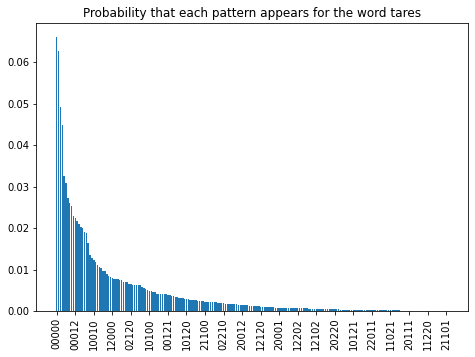

In [147]:
#plotting probability map for example word -> how likely each pattern is
guess = "tares"
df = guess_probability_map(guess, all_allowed)

x = df.index.values.tolist()
# for i in range (len(x)):
#     x[i] = wordle_print(x[i])
y = df["Probability"].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.xticks(np.arange(0, len(x)+1, 10), rotation=90)

plt.title(f"Probability that each pattern appears for the word {guess}")
plt.show()

In [129]:
df

,Probability
00000,0.583629
01000,0.074765
00002,0.069370
02000,0.061122
00001,0.046092
...,...
00221,0.000077
11002,0.000077
22202,0.000077
22220,0.000077


In [167]:
#build dataframe with words & expected entropy and save as df
# #for solutions
# entropies_all = []
# for word in alive_it(solutions, force_tty=True, bar = "classic2", spinner = "loving"):
#     entropies_all.append(expected_entropy_from_word(word))

# df = pd.DataFrame(list(zip(solutions, entropies_all)), columns = ["Word", "E[I]"])
# df = df.sort_values(by=['E[I]'], ascending=False)
# df.to_csv('solutions_E[I].csv', index=False)

# #for allowed_words (not all_allowed!)
# entropies_all = []
# for word in alive_it(allowed_words, force_tty=True, bar = "classic2", spinner = "loving"):
#     entropies_all.append(expected_entropy_from_word(word))

# df = pd.DataFrame(list(zip(allowed_words, entropies_all)), columns = ["Word", "E[I]"])
# df = df.sort_values(by=['E[I]'], ascending=False)
# df.to_csv('allowed_words_E[I].csv', index=False)

solutions_EI = pd.read_csv('solutions_E[I].csv', header=0, index_col=0, squeeze=True).to_dict()
allowed_EI = pd.read_csv('allowed_words_E[I].csv', header=0, index_col=0, squeeze=True).to_dict()
all_allowed_EI = {**allowed_EI, **solutions_EI}


for i in (solutions_EI, allowed_EI, all_allowed_EI):
    best_guess = max(i.keys(), key=(lambda k: i[k]))
    worst_guess = min(i.keys(), key=(lambda k: i[k]))

    print(f"best guess:\t{best_guess}\t{i[best_guess]:.3}")
    print(f"worst guess:\t{worst_guess}\t{i[worst_guess]:.3}\n")

best guess:	saner	6.0
worst guess:	fluff	2.35

best guess:	tares	6.19
worst guess:	qajaq	2.07

best guess:	tares	6.19
worst guess:	qajaq	2.07



In [182]:
#Wordle algorithm with expected entropy
max_tries = 100000
taken_tries = []

for s in alive_it(random.sample(solutions, 30), force_tty=True, bar = "classic2", spinner = "classic"):
    reduced_list = sorted(all_allowed)
    entropies_sorted = list(sorted(all_allowed_EI.items()))
    entropies_list = list(np.array(entropies_sorted)[:,1])      

    #print(s)
    for i in range(max_tries):
        guess = reduced_list[entropies_list.index(max(entropies_list))]
        EI = float(max(entropies_list))
        reply = wrdl.wordle_reply(s, guess)
        if sum(reply) == 10: 
            inf = math.log2(1/(1/len(reduced_list)))
            #print(wrdl.wordle_print(reply), guess, f"E[I]:{EI:.2f} bits ", f"I:{inf:.2f} bits ", f"EPIC WIN!!!")
            break
    
        reduced_list_before = reduced_list
        reduced_list = wrdl.filter_words(guess, reply, allowed_words = reduced_list)
        p = len(reduced_list) / len(reduced_list_before)  
        inf = math.log2(1/p)

        #print(wrdl.wordle_print(reply), guess, f"E[I]:{EI:.2f} bits ", f"I:{inf:.2f} bits ", f"{len(reduced_list)} words")

        entropies_list = []
        for word in reduced_list:
            entropies_list.append(expected_entropy_from_word(word, word_list = reduced_list))

    taken_tries.append(i+1)
    clear_output(wait=True)

sleep(1)
print(f"Average number of tries: {sum(taken_tries)/len(taken_tries):.2}")

[########################################] 30/30 [100%] in 4:21.1 (0.11/s)                                              
Average number of tries: 4.1


In [138]:
#Wordle algorithm with expected entropy to cheat
reduced_list = sorted(solutions)
entropies_sorted = list(sorted(solutions_EI.items()))
entropies_list = list(np.array(entropies_sorted)[:,1])      

for i in range(6):
    guess = reduced_list[entropies_list.index(max(entropies_list))]
    print(guess)
    sleep(1)
    EI = float(max(entropies_list))
    reply = [int(item) for item in input("Wordl reply e.g. 0 2 1 0 0").split()]
    if sum(reply) == 10: 
        print(wrdl.wordle_print(reply), guess, f"E[I]:{EI:.2f} bits ", f"I:{inf:.2f} bits ", f"EPIC WIN!!!")
        break

    reduced_list_before = reduced_list
    reduced_list = wrdl.filter_words(guess, reply, allowed_words = reduced_list)
    p = len(reduced_list) / len(reduced_list_before)  
    inf = math.log2(1/p)

    print(wrdl.wordle_print(reply), guess, f"E[I]:{EI:.2f} bits ", f"I:{inf:.2f} bits ", f"{len(reduced_list)} words")

    entropies_list = []
    for word in reduced_list:
        entropies_list.append(expected_entropy_from_word(word, word_list = reduced_list))

saner
⬜⬜⬜⬜⬜ saner E[I]:6.00 bits  I:3.40 bits  219 words
could
⬜⬜⬜⬜⬜ could E[I]:5.51 bits  I:3.53 bits  19 words
fight
⬜🟩⬜⬜🟨 fight E[I]:3.75 bits  I:2.66 bits  3 words
bitty
⬜🟩🟩🟩🟩 bitty E[I]:0.92 bits  I:0.58 bits  2 words
kitty
⬜🟩🟩🟩🟩 kitty E[I]:1.00 bits  I:1.00 bits  1 words
witty
🟩🟩🟩🟩🟩 witty E[I]:0.00 bits  I:1.00 bits  EPIC WIN!!!


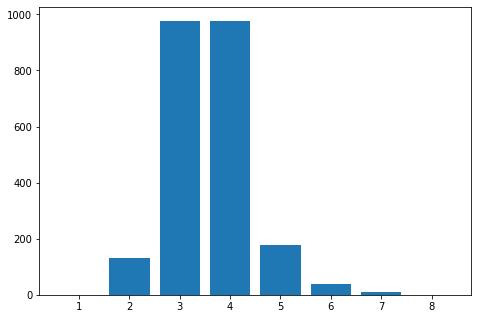

In [56]:
bars = []
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for i in range(1, max(taken_tries)+1):
    bars.append(taken_tries.count(i))
ax.bar(range(1, max(taken_tries)+1), bars)
plt.show()

In [11]:
p.stop

Playing Wordle intensively [##################......................] | 1067/2309 [46%] in 39s (27.7/s, eta: 45s) 

NameError: name 'p' is not defined